In [59]:
# Data Processing
import pandas as pd
import numpy as np
import re
from numpy import mean, std

# Data visualization
!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Creating the modeling dataset
from sklearn.datasets import make_classification

# Feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Model and performance
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     RandomizedSearchCV,
                                     cross_val_score, 
                                     KFold, 
                                     RepeatedKFold)
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay,
                             matthews_corrcoef)
from sklearn.metrics import classification_report
from datetime import datetime
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Over sampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

# Treating data imbalance
!pip install -U imbalanced-learn

# checking memory space usage
import tracemalloc

# normality check
import math
from scipy.stats import shapiro #shapiro-wilk test

import warnings
warnings.filterwarnings("ignore")

## Loading and prepraing dataset

In [2]:
# Loading dataset
df1 = pd.read_csv('adult_data.csv', header = None, na_values =' ?') # Passing ' ?' as na_values
df2 = pd.read_csv('adult_test.csv', header = None, na_values =' ?') # Passing ' ?' as na_values
df = pd.concat([df1, df2], ignore_index = True)
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation', 'relationship','race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
                'country', 'income']
df.columns = column_names

# Changing the target variable class from categorical to numerical
df_mod = df.copy()
df_mod['income'] = df_mod['income'].str.replace('<=50K.', '<=50K',regex=False)
df_mod['income'] = df_mod['income'].str.replace('>50K.', '>50K', regex=False)
income_map={' <=50K':0,' >50K':1}
df_mod['income']=df_mod['income'].map(income_map).astype(int)
df_mod.income.value_counts()

# Aggregating class levels of 'Education' category
df_mod['education'] = df_mod['education'].str.replace('11th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('9th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('7th-8th','Junior-High', regex = True)
df_mod['education'] = df_mod['education'].str.replace('5th-6th', 'Primary', regex = True)
df_mod['education'] = df_mod['education'].str.replace('10th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('1st-4th','Primary', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Preschool','Pre-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('12th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Bachelors','Bachelors', regex = True)
df_mod['education'] = df_mod['education'].str.replace('HS-grad','HS-grad', regex = True)
df_mod['education'] = df_mod['education'].replace(['Masters', 'Prof-school'],'Masters', regex = True)
df_mod['education'] = df_mod['education'].replace(['Some-college','Assoc-acdm', 'Assoc-voc'],'College', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Doctorate','Doctorate', regex = True)
df_mod['education'].unique()

# Dropping Duplicates
df_mod = df_mod.drop_duplicates()

# Removing missing values
x = df_mod.copy()
df_m1 = x.dropna()

# Data Encoding
df_m1_num = df_m1.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'country'], axis=1)
df_encoded1 = pd.get_dummies(df_m1[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'country']],)
df_encoded1 = pd.concat([df_encoded1, df_m1_num], axis=1)
df_encoded1

# Train-test split for df_encoded1 dataset
X = df_encoded1.drop('income', axis=1) # all independent variables execpt the target 'income'
y = df_encoded1['income'] # Target variable
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3)
print("The number of records in the training set is", X_train1.shape[0])
print("The number of records in the test set is", X_test1.shape[0])

The number of records in the training set is 31622
The number of records in the test set is 13553


## XGBoost: Baseline model

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     10169
           1       0.78      0.65      0.71      3384

    accuracy                           0.87     13553
   macro avg       0.83      0.80      0.81     13553
weighted avg       0.86      0.87      0.86     13553



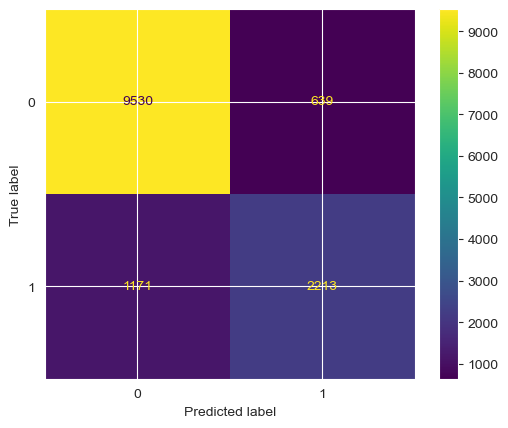

MCC score: 0.63


In [78]:
# XGBoost on df_encoded1 data

cf = XGBClassifier()
X_train = X_train1
X_test = X_test1
y_train = y_train1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Check the model performance
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()
print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

## XGBoost: Class Imbalance treated data and tuning hyper parameters

Important hyper-parameters that we will fine tune are :
* Max_depth
* Subsample
* colsample_bylevel
* colsample_bytree
* min_child_weight
* n_estimators
* learning_rate

### Random oversampled data

              precision    recall  f1-score   support

           0       0.94      0.83      0.89     10169
           1       0.63      0.85      0.72      3384

    accuracy                           0.84     13553
   macro avg       0.79      0.84      0.81     13553
weighted avg       0.87      0.84      0.85     13553



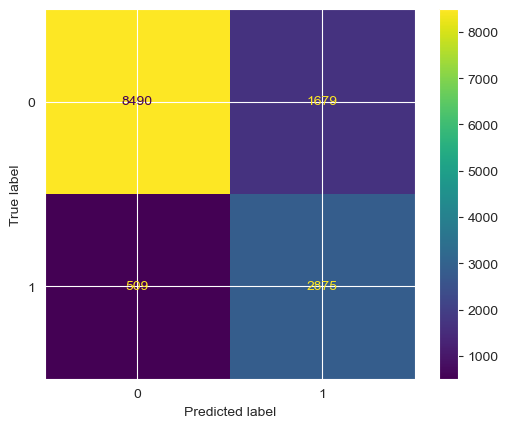

MCC score: 0.63


In [79]:
# Random Oversampling
ros = RandomOverSampler()
X_train_ros1, y_train_ros1 = ros.fit_resample(X_train1, y_train1)


# Running model
cf = XGBClassifier()
X_train = X_train_ros1
X_test = X_test1
y_train = y_train_ros1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)


# Check the model performance
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

              precision    recall  f1-score   support

           0       0.95      0.83      0.88     10169
           1       0.63      0.87      0.73      3384

    accuracy                           0.84     13553
   macro avg       0.79      0.85      0.81     13553
weighted avg       0.87      0.84      0.84     13553



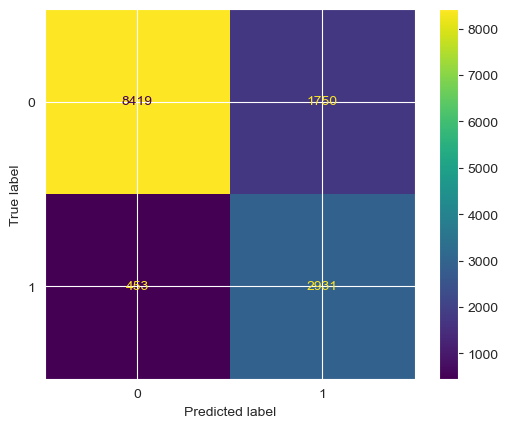

MCC score: 0.63


In [80]:
# Random Oversampling
ros = RandomOverSampler()
X_train_ros1, y_train_ros1 = ros.fit_resample(X_train1, y_train1)


# Running model
cf = XGBClassifier(max_depth = 6,
                   subsample = 1,
                   n_estimators = 100,
                   learning_rate = 0.2,
                   min_child_weight = 1)
X_train = X_train_ros1
X_test = X_test1
y_train = y_train_ros1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)


# Check the model performance
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

### SMOTE Oversampled data

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     10169
           1       0.76      0.68      0.71      3384

    accuracy                           0.87     13553
   macro avg       0.83      0.80      0.81     13553
weighted avg       0.86      0.87      0.86     13553



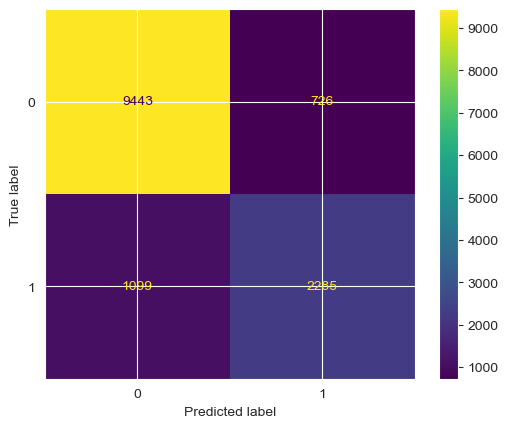

MCC score: 0.63


In [81]:
# SMOTE Oversampling
smote1 = SMOTE()
X_train_smote1, y_train_smote1 = smote1.fit_resample(X_train1, y_train1)

# Running model
cf = XGBClassifier()
X_train = X_train_smote1
X_test = X_test1
y_train = y_train_smote1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Check the model performance
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     10169
           1       0.76      0.68      0.72      3384

    accuracy                           0.87     13553
   macro avg       0.83      0.80      0.81     13553
weighted avg       0.86      0.87      0.86     13553



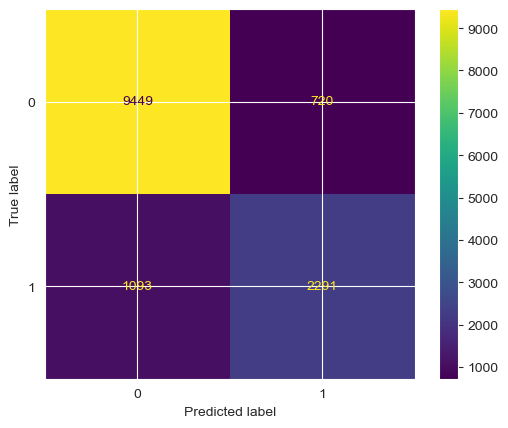

MCC score: 0.63


In [82]:
# SMOTE Oversampling
smote1 = SMOTE()
X_train_smote1, y_train_smote1 = smote1.fit_resample(X_train1, y_train1)

# Running model
cf = XGBClassifier(max_depth = 6,
                   subsample = 1,
                   n_estimators = 100,
                   learning_rate = 0.3,
                   min_child_weight = 1,
                   colsample_bytree = 0.3)
X_train = X_train_smote1
X_test = X_test1
y_train = y_train_smote1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Check the model performance
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

### Random Undersampled data

              precision    recall  f1-score   support

           0       0.95      0.81      0.88     10169
           1       0.61      0.87      0.72      3384

    accuracy                           0.83     13553
   macro avg       0.78      0.84      0.80     13553
weighted avg       0.86      0.83      0.84     13553



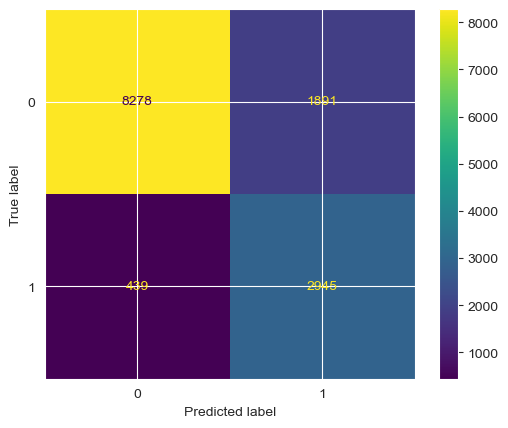

MCC score: 0.62


In [83]:
# Random Undersampling
rus1 = RandomUnderSampler()
X_train_rus1, y_train_rus1 = rus1.fit_resample(X_train1, y_train1)

# Running model
cf = XGBClassifier()
X_train = X_train_rus1
X_test = X_test1
y_train = y_train_rus1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Check the model performance
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     10169
           1       0.61      0.87      0.72      3384

    accuracy                           0.83     13553
   macro avg       0.78      0.84      0.80     13553
weighted avg       0.87      0.83      0.84     13553



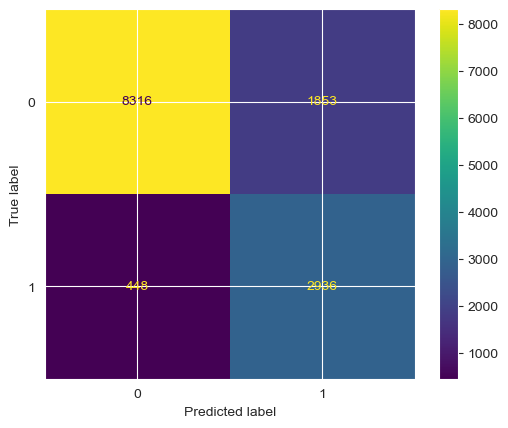

MCC score: 0.62


In [84]:
# Random Undersampling
rus1 = RandomUnderSampler()
X_train_rus1, y_train_rus1 = rus1.fit_resample(X_train1, y_train1)

# Running model
cf = XGBClassifier(max_depth = 6,
                   subsample = 1,
                   n_estimators = 100,
                   learning_rate = 0.3,
                   min_child_weight = 1,
                   colsample_bytree = 0.3)
X_train = X_train_rus1
X_test = X_test1
y_train = y_train_rus1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Check the model performance
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

### NearMiss Undersampled data

              precision    recall  f1-score   support

           0       0.95      0.81      0.87     10169
           1       0.60      0.87      0.71      3384

    accuracy                           0.82     13553
   macro avg       0.77      0.84      0.79     13553
weighted avg       0.86      0.82      0.83     13553



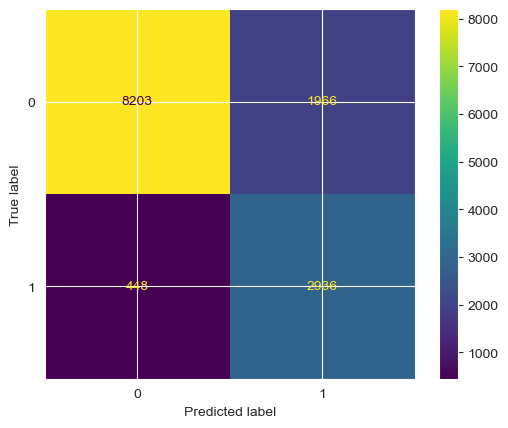

MCC score: 0.61


In [85]:
# NearMiss Undersampling
nearmiss1 = NearMiss(version=3)
X_train_nearmiss1, y_train_nearmiss1 = nearmiss1.fit_resample(X_train1, y_train1)

cf = XGBClassifier()
X_train = X_train_nearmiss1
X_test = X_test1
y_train = y_train_nearmiss1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Check the model performance
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

              precision    recall  f1-score   support

           0       0.95      0.81      0.87     10169
           1       0.60      0.87      0.71      3384

    accuracy                           0.82     13553
   macro avg       0.77      0.84      0.79     13553
weighted avg       0.86      0.82      0.83     13553



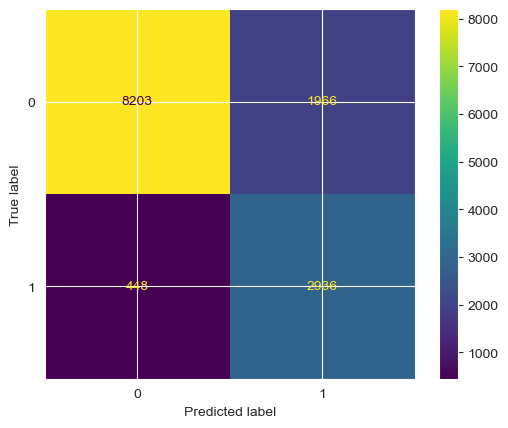

MCC score: 0.61


In [86]:
# NearMiss Undersampling
nearmiss1 = NearMiss(version=3)
X_train_nearmiss1, y_train_nearmiss1 = nearmiss1.fit_resample(X_train1, y_train1)

cf = XGBClassifier(max_depth = 6,
                   subsample = 1,
                   n_estimators = 100,
                   learning_rate = 0.3,
                   min_child_weight = 1,
                   colsample_bytree = 1)
X_train = X_train_nearmiss1
X_test = X_test1
y_train = y_train_nearmiss1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Check the model performance
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

## Cross Validation

### Timer setup

In [27]:
# Creating a timer to check time-lapse
# from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### Memory usage tracker setup

In [28]:
# memory space usage tracking
# import tracemalloc 
def app():
    lt = []
    for i in range(0, 100000):
        lt.append(i)

### K-Fold Cross Validation

In [29]:
# from sklearn.model_selection import cross_val_score
# K-Fold Cross validation on base dataset

cf = XGBClassifier()

# starting timer
start_time = timer(None)

# starting the memory monitoring
tracemalloc.start()

# function call
app()

# running cross-val
kfold_score = [cross_val_score (cf, X_train1, y_train1, scoring='accuracy', cv=5)]

# time stopper
timer(start_time)

# displaying the memory (current, peak)
print('memory usage: Current, Peak', tracemalloc.get_traced_memory())
 
# stopping the memorylibrary
tracemalloc.stop()

print(kfold_score)
print(np.average(kfold_score))


 Time taken: 0 hours 0 minutes and 20.86 seconds.
memory usage: Current, Peak (88482, 25512855)
[array([0.87067194, 0.87288538, 0.86527514, 0.86321948, 0.8673308 ])]
0.8678765478395872


### Repeated K-Fold Cross Validation

In [77]:
# Repeated K-Fold on base dataset

cv1 = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cf = cf = XGBClassifier()

# starting timer
start_time = timer(None)

# starting the memory monitoring
tracemalloc.start()

# function call
app()
 
# running cross-val
repeatK_scores = cross_val_score(cf, X_train1, y_train1, scoring='accuracy', cv=cv1)

# time stopper
timer(start_time)

# displaying the memory (current, peak)
print('memory usage: Current, Peak', tracemalloc.get_traced_memory())
 
# stopping the memorylibrary
tracemalloc.stop()

print (repeatK_scores)
print('Accuracy: %.3f (%.3f)' % (mean(repeatK_scores), std(repeatK_scores)))


 Time taken: 0 hours 3 minutes and 13.18 seconds.
memory usage: Current, Peak (72780, 28139012)
[0.87322163 0.86942776 0.86495889 0.86780519 0.86306135 0.86685642
 0.87191651 0.86464263 0.87349779 0.871284   0.87511856 0.86784698
 0.86590765 0.87381404 0.86116382 0.87065149 0.86432638 0.8655914
 0.86622391 0.86116382 0.86405311 0.86373696 0.87666034 0.86432638
 0.86685642 0.8655914  0.87507906 0.86907021 0.86748893 0.86875395]
Accuracy: 0.868 (0.004)


### Checking the distribution of repeated K-Fold scores

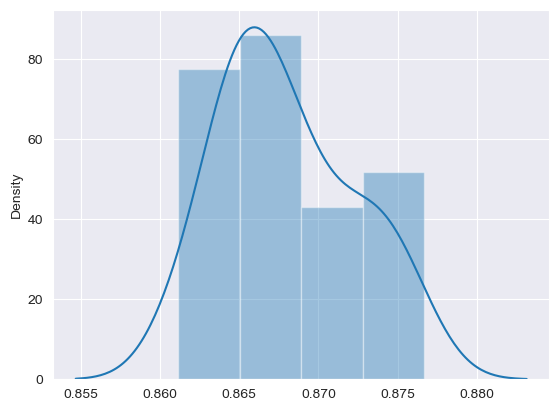

In [63]:
sns.set_style('darkgrid')
sns.distplot(repeatK_scores);

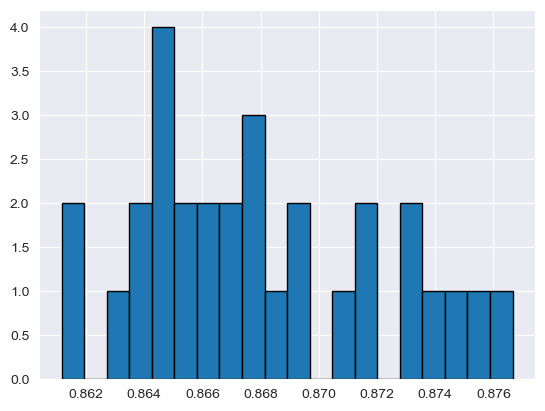

In [64]:
plt.hist(repeatK_scores, edgecolor='black', bins=20);

### Normality check through Shapiro-Wilk Test

In [65]:
# normality check for the repeatK_scores

shapiro(repeatK_scores)

ShapiroResult(statistic=0.9555113315582275, pvalue=0.23687216639518738)

From the output, we can see that p-value is greater than 0.05 which means that we have sufficient evidence to accept the null hypothesis which is the data is normally distributed

## Variance check

In [70]:
xgbscore = repeatK_scores.T
xgbscore

array([0.87322163, 0.86942776, 0.86495889, 0.86780519, 0.86306135,
       0.86685642, 0.87191651, 0.86464263, 0.87349779, 0.871284  ,
       0.87511856, 0.86784698, 0.86590765, 0.87381404, 0.86116382,
       0.87065149, 0.86432638, 0.8655914 , 0.86622391, 0.86116382,
       0.86405311, 0.86373696, 0.87666034, 0.86432638, 0.86685642,
       0.8655914 , 0.87507906, 0.86907021, 0.86748893, 0.86875395])

In [71]:
df = pd.read_csv('Repeated K-Fold Cross Validation Scores.csv')
df.head()

,RF
0,0.853620
1,0.853936
2,0.851044
3,0.836180
4,0.860215


In [73]:
df['XGB'] = XGB
df.head()

,RF,XGB
0,0.853620,0.873222
1,0.853936,0.869428
2,0.851044,0.864959
3,0.836180,0.867805
4,0.860215,0.863061


In [74]:
df.to_csv('Repeated K-Fold Cross Validation Scores.csv', index=False)